# Project enda : Example B


If you haven't already, read Example A first, it is not long.

In this example we will see a more realistic example :
- realistic data (but not real data)
- more historical data (~4-5 years)
- datetime and calendar feature engineering
- portfolio forecast
- still a very basic algorithm, and we consider all customers in one big group here
- backtesting 

We set ourselves in a setup as if we were **exactly on 2020-11-30**.
We want to predict the total consumption of customers for the next few days starting 2020-12-01 at a 30min time-step. 
We have:
- our customer contracts until 2020-11-30 included.
- historical load data from 2015-01-01 until 2020-11-15 included.
- weather forecast until 2020-12-11 (11 days).
- our TSO's network load forecast until 2020-12-7 (7 days).

In here (example B), we will put all our customers in only 1 group and forecast the next 7 days. We will first construct the dataset and the forecast input data and test it with a basic linear regressor. We will then try various algorithms and compare them. Finally we will give an example of backtesting on the data.  



In [1]:
import enda
import pandas as pd
import os
import enda.ml_backends.sklearn_linreg  
from enda.ml_backends.sklearn_linreg import SKLearnLinearRegression
import joblib

## 1. Import data (from files)

In [2]:
# copy the dataset found in enda/tests/example_b/ locally, and replace DIR with your path 
DIR = '/Users/emmanuel.charon/Documents/CodeProjects/enercoop/enda/data/example_b'
TODAY = pd.to_datetime('2020-11-30 00:00:00+01:00').astimezone('Europe/Paris')
TOMORROW = pd.to_datetime('2020-12-01 00:00:00+01:00').astimezone('Europe/Paris')

In [3]:
# get the 30min time-step data just like in Example A (columns are a bit different and there is more data)
# here we consider all customers in one big group
def read_data():
    contracts = enda.Contracts.read_contracts_from_file(os.path.join(DIR, "contracts.csv"))
    contracts["group"] = "one_group"
    contracts["num_contracts"] = 1
    portfolio_by_day = enda.Contracts.compute_portfolio_by_day(
        contracts, 
        columns_to_sum = ["num_contracts", "kva"],
        date_start_col="date_start",
        date_end_exclusive_col="date_end_exclusive",
        group_column="group"
    )
    portfolio = enda.TimeSeries.interpolate_daily_to_sub_daily_data(
        portfolio_by_day, 
        freq='30min', 
        tz='Europe/Paris'
    )
    portfolio.columns = portfolio.columns.droplevel(1) # just need a regular index not a multi-index here
    
    
    historic_load_measured = pd.read_csv(os.path.join(DIR, "historic_load_measured.csv"))
    weather_and_tso_forecasts = pd.read_csv(os.path.join(DIR, "weather_and_tso_forecasts.csv"))
    # correctly format 'time' as a pandas.DatetimeIndex of dtype: datetime[ns, tzinfo]
    for df in [historic_load_measured, weather_and_tso_forecasts]:
        df['time'] = pd.to_datetime(df['time'])
        df['time'] = enda.TimeSeries.align_timezone(df['time'], tzinfo = 'Europe/Paris')
        df.set_index('time', inplace=True)
     
    # keep only where both loads are known
    historic_load_measured = historic_load_measured.dropna()
    historic_load_measured["load_kw"] = historic_load_measured["smart_metered_kw"] + historic_load_measured["slp_kw"]
    # keep only the full load
    historic_load_measured = historic_load_measured[["load_kw"]]
    
        
    return contracts, portfolio, historic_load_measured, weather_and_tso_forecasts  

In [4]:
contracts, portfolio, historic_load_measured, weather_and_tso_forecasts = read_data()
# remove data where tso is not available
weather_and_tso_forecasts = weather_and_tso_forecasts.dropna(subset=["tso_forecast_load_mw"])

In [5]:
contracts

,date_start,date_end_exclusive,kva,meter_reading_type,group,num_contracts
0,2006-08-09,NaT,12.0,PROFILE,one_group,1
1,2006-09-01,2006-11-23,6.0,PROFILE,one_group,1
2,2006-09-01,2007-11-01,3.0,PROFILE,one_group,1
3,2006-09-01,2007-12-19,12.0,PROFILE,one_group,1
4,2006-09-01,2008-06-28,12.0,PROFILE,one_group,1
...,...,...,...,...,...,...
162598,2020-11-30,NaT,6.0,PROFILE,one_group,1
162599,2020-11-30,NaT,6.0,PROFILE,one_group,1
162600,2020-11-30,NaT,6.0,PROFILE,one_group,1
162601,2020-11-30,NaT,6.0,PROFILE,one_group,1


In [6]:
portfolio

measure,kva,num_contracts
time,,
2006-08-09 00:00:00+02:00,12.0,1.0
2006-08-09 00:30:00+02:00,12.0,1.0
2006-08-09 01:00:00+02:00,12.0,1.0
2006-08-09 01:30:00+02:00,12.0,1.0
2006-08-09 02:00:00+02:00,12.0,1.0
...,...,...
2020-11-30 21:30:00+01:00,820005.7,96134.0
2020-11-30 22:00:00+01:00,820005.7,96134.0
2020-11-30 22:30:00+01:00,820005.7,96134.0


In [7]:
historic_load_measured

,load_kw
time,
2015-01-01 00:00:00+01:00,2490.925806
2015-01-01 00:30:00+01:00,2412.623113
2015-01-01 01:00:00+01:00,2365.611276
2015-01-01 01:30:00+01:00,2336.141065
2015-01-01 02:00:00+01:00,2300.935642
...,...
2020-11-15 21:30:00+01:00,7657.293444
2020-11-15 22:00:00+01:00,7317.540759
2020-11-15 22:30:00+01:00,7580.051439


In [8]:
# t_weighted is the average french temperature weighted by population density
# t_smooth is a smoothing computed over t_weighted to take into account building calorific inertia
weather_and_tso_forecasts

,tso_forecast_load_mw,t_weighted,t_smooth
time,,,
2015-01-01 00:00:00+01:00,72900.0,-0.41,1.17
2015-01-01 00:30:00+01:00,71600.0,-0.48,1.17
2015-01-01 01:00:00+01:00,69900.0,-0.55,1.15
2015-01-01 01:30:00+01:00,70600.0,-0.66,1.14
2015-01-01 02:00:00+01:00,70500.0,-0.78,1.11
...,...,...,...
2020-12-07 21:30:00+01:00,68400.0,4.20,4.13
2020-12-07 22:00:00+01:00,66900.0,4.12,4.10
2020-12-07 22:30:00+01:00,67600.0,4.03,4.08


In [9]:
# lets create the train set with historical data
historic = pd.merge(
    portfolio, 
    historic_load_measured, # here we select only the load of the desired group
    how='inner', left_index=True, right_index=True
)

historic = pd.merge(
    historic, 
    weather_and_tso_forecasts, 
    how='inner', left_index=True, right_index=True
)

In [10]:
historic

,kva,num_contracts,load_kw,tso_forecast_load_mw,t_weighted,t_smooth
time,,,,,,
2015-01-01 00:00:00+01:00,167416.4,21261.0,2490.925806,72900.0,-0.41,1.17
2015-01-01 00:30:00+01:00,167416.4,21261.0,2412.623113,71600.0,-0.48,1.17
2015-01-01 01:00:00+01:00,167416.4,21261.0,2365.611276,69900.0,-0.55,1.15
2015-01-01 01:30:00+01:00,167416.4,21261.0,2336.141065,70600.0,-0.66,1.14
2015-01-01 02:00:00+01:00,167416.4,21261.0,2300.935642,70500.0,-0.78,1.11
...,...,...,...,...,...,...
2020-11-15 21:30:00+01:00,813328.8,95475.0,7657.293444,46200.0,12.05,12.01
2020-11-15 22:00:00+01:00,813328.8,95475.0,7317.540759,45200.0,11.92,11.97
2020-11-15 22:30:00+01:00,813328.8,95475.0,7580.051439,46400.0,11.84,11.96


In [11]:
# check that there is no NaN value
historic.isna().sum()

kva                     0
num_contracts           0
load_kw                 0
tso_forecast_load_mw    0
t_weighted              0
t_smooth                0
dtype: int64

In [12]:
# check missing data in the timeseries (based on the time index only)
freq, missing_periods, extra_points = enda.TimeSeries.find_missing_and_extra_periods(
    dti=historic.index, 
    expected_freq = '30min',
    expected_start_datetime = pd.to_datetime('2015-01-01 00:00:00+01:00').astimezone('Europe/Paris'),
    expected_end_datetime = pd.to_datetime('2020-11-30 23:30:00+01:00').astimezone('Europe/Paris')
)
for missing_period in missing_periods:
    print("Missing data from {} to {}.".format(missing_period[0], missing_period[1]))
if len(extra_points) > 0 :
    print("Extra points found: {}".format(extra_points))


Missing data from 2015-09-01 00:00:00+02:00 to 2015-11-30 23:30:00+01:00.
Missing data from 2018-06-01 00:00:00+02:00 to 2018-06-30 23:30:00+02:00.
Missing data from 2020-11-16 00:00:00+01:00 to 2020-11-30 23:30:00+01:00.


## 2. Visualize data 
To visualise using pandas, you need matplotlib
```bash
pip install matplotlib
```

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

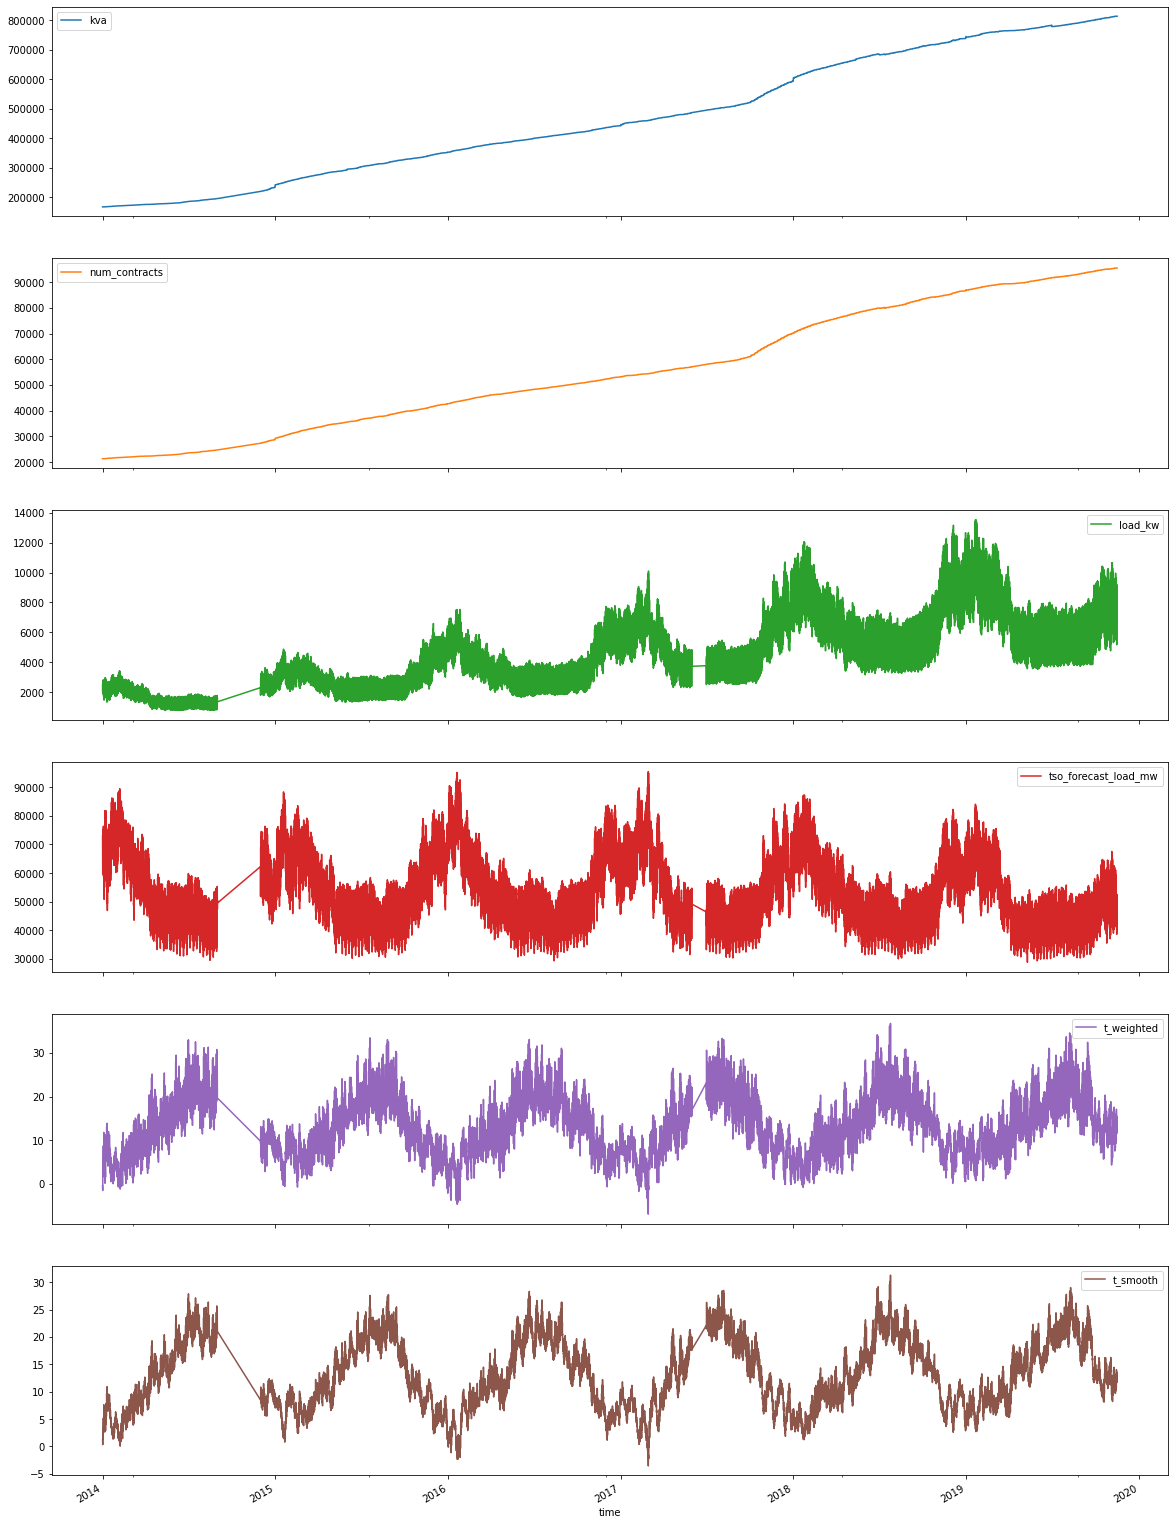

In [13]:
# Show full data set
historic.plot(figsize=(20, 30), subplots=True)

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

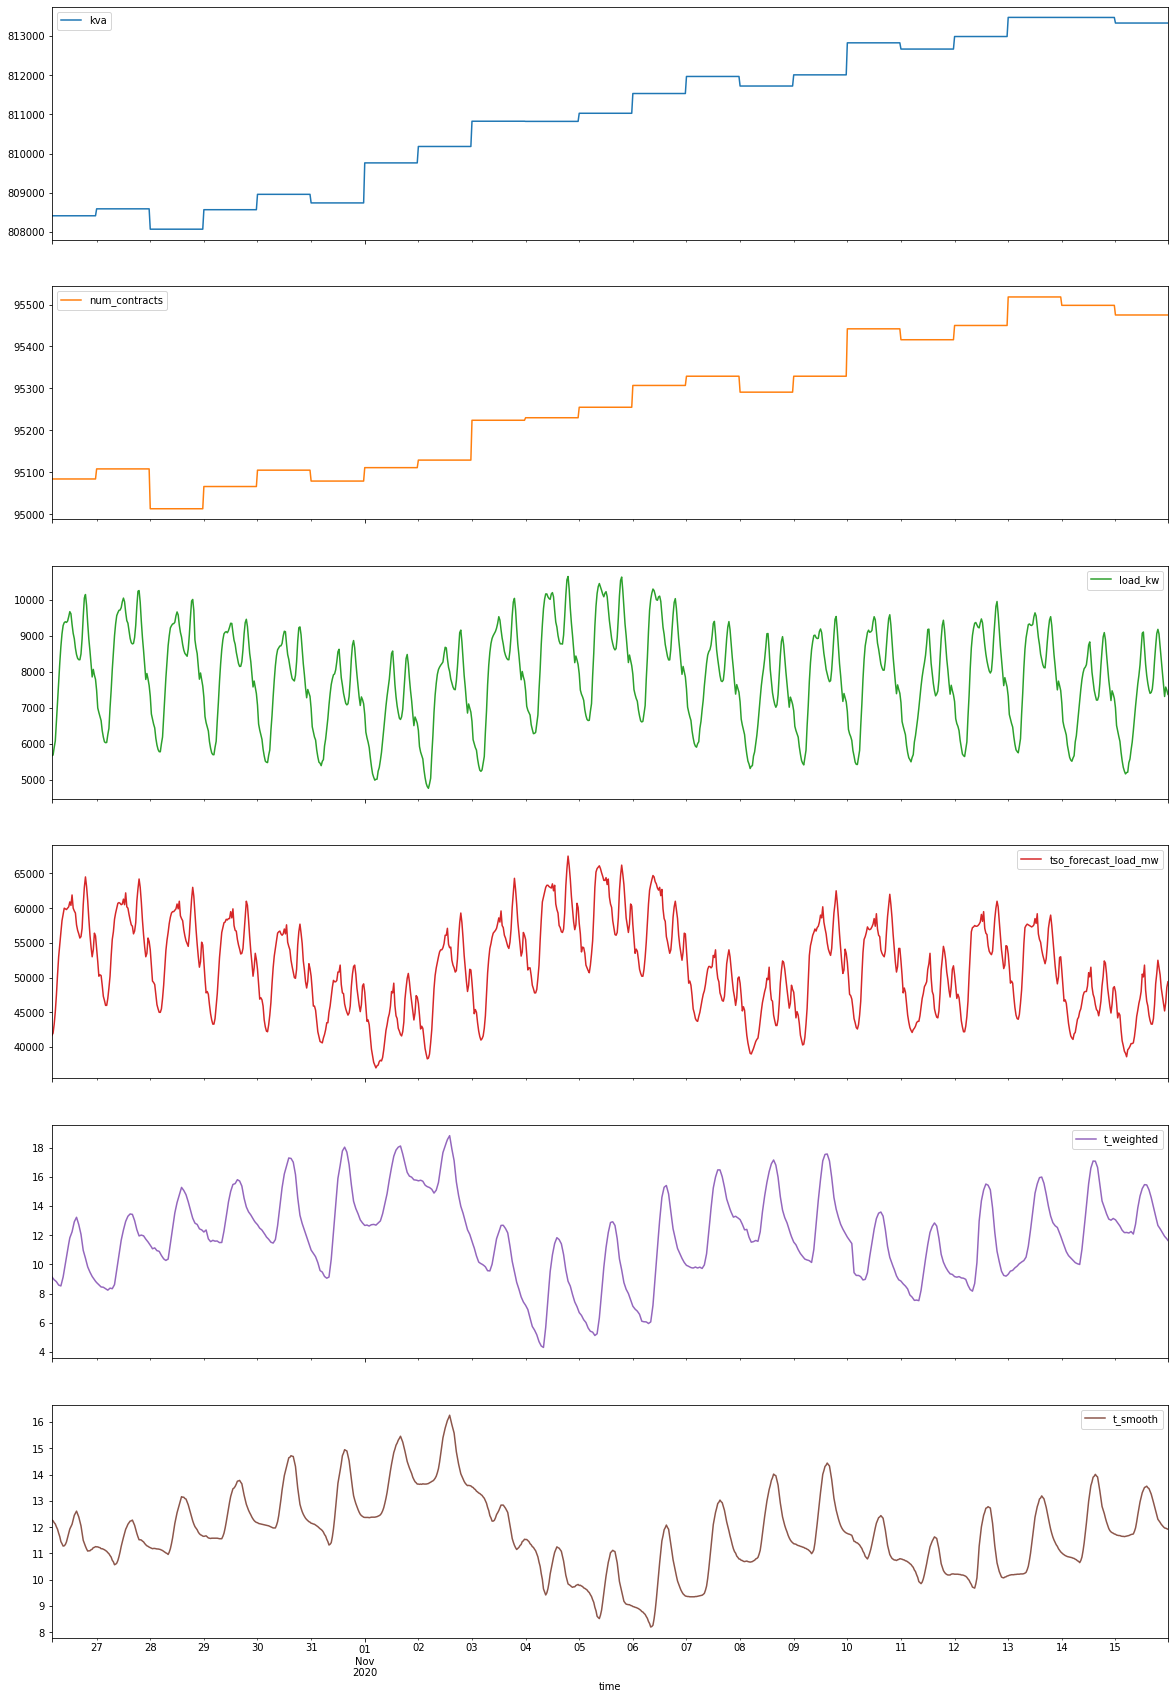

In [14]:
# Show recent data 
historic[-1000:].plot(figsize=(20, 30), subplots=True)

Don't hesitate to add your own visualisations!

## 3. Feature engineering

Before we train, we will add some features based on the `datetime`, and some calendar features related to national holidays or school holydays.

We use some packages for the holidays, which are used in **enda.feature_engineering.calendar**  : 
```bash
pip install jours-feries-france vacances-scolaires-france Unidecode
```


In [15]:
import enda.feature_engineering.calendar

In [16]:
# define the features we want to add before training/predicting
def featurize(df):
    # put datetime features to capture the data frequencies: daily, weekly and yearly periods.  
    df = enda.DatetimeFeature.split_datetime(
        df, split_list = ['minuteofday', 'dayofweek', 'month']
    )
    df = enda.DatetimeFeature.encode_cyclic_datetime_index(
        df, split_list = ['minuteofday', 'dayofweek', 'dayofyear']
    )
    special_days = enda.feature_engineering.calendar.Calendar().get_french_special_days() 
    df = pd.merge(
        df, special_days,
        how='left', left_index=True, right_index=True
    )
    return df
    

In [17]:
train_set = featurize(historic)

In [18]:
train_set

,kva,num_contracts,load_kw,tso_forecast_load_mw,t_weighted,t_smooth,minuteofday,dayofweek,month,minuteofday_cos,minuteofday_sin,dayofweek_cos,dayofweek_sin,dayofyear_cos,dayofyear_sin,lockdown,public_holiday,nb_school_areas_off,extra_long_weekend
time,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,167416.4,21261.0,2490.925806,72900.0,-0.41,1.17,0,3,1,1.000000,0.000000,-0.900969,0.433884,1.000000,0.000000,0.0,1.0,3.0,0.0
2015-01-01 00:30:00+01:00,167416.4,21261.0,2412.623113,71600.0,-0.48,1.17,30,3,1,0.991445,0.130526,-0.900969,0.433884,1.000000,0.000000,0.0,1.0,3.0,0.0
2015-01-01 01:00:00+01:00,167416.4,21261.0,2365.611276,69900.0,-0.55,1.15,60,3,1,0.965926,0.258819,-0.900969,0.433884,1.000000,0.000000,0.0,1.0,3.0,0.0
2015-01-01 01:30:00+01:00,167416.4,21261.0,2336.141065,70600.0,-0.66,1.14,90,3,1,0.923880,0.382683,-0.900969,0.433884,1.000000,0.000000,0.0,1.0,3.0,0.0
2015-01-01 02:00:00+01:00,167416.4,21261.0,2300.935642,70500.0,-0.78,1.11,120,3,1,0.866025,0.500000,-0.900969,0.433884,1.000000,0.000000,0.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-15 21:30:00+01:00,813328.8,95475.0,7657.293444,46200.0,12.05,12.01,1290,6,11,0.793353,-0.608761,0.623490,-0.781831,0.691771,-0.722117,0.0,0.0,0.0,0.0
2020-11-15 22:00:00+01:00,813328.8,95475.0,7317.540759,45200.0,11.92,11.97,1320,6,11,0.866025,-0.500000,0.623490,-0.781831,0.691771,-0.722117,0.0,0.0,0.0,0.0
2020-11-15 22:30:00+01:00,813328.8,95475.0,7580.051439,46400.0,11.84,11.96,1350,6,11,0.923880,-0.382683,0.623490,-0.781831,0.691771,-0.722117,0.0,0.0,0.0,0.0


In [19]:
# train a basic SKLearnLinearRegression
lin_reg = SKLearnLinearRegression()
lin_reg.train(train_set, target_col='load_kw')

In [20]:
# run a self.eval on the trainset:
train_set_predict = lin_reg.predict(train_set.drop(columns=['load_kw']), target_col='load_kw')
self_eval = pd.merge(
    train_set_predict.rename(columns={'load_kw':"predict_kw"}),
    train_set['load_kw'].to_frame("historic_kw"), 
    how='inner', left_index=True, right_index=True
)
# compute absolute percentage error
self_eval["ape"] = (self_eval["predict_kw"] - self_eval["historic_kw"]).abs()/self_eval["historic_kw"]*100
self_eval["ape"].mean()
        

14.85868098815133

## 4. Lets create the forecast input data and do a first prediction

We need an estimate of our portfolio in the next few days, the tso_load and weather forecasts. 

In order to get our portfolio in the next few days, here we will just consider the latest trends in our portfolio. 

In another setup, you might want to connect to your sales software or ERP and take into account contracts that will end or start soon.

We will use `enda.Contracts.forecast_using_trend`which requires the `statsmodel` package : 
```bash
pip install statsmodel
```

In [21]:
# we will forecast the portfolio using holt method 
forecast_portfolio =  enda.Contracts.forecast_using_trend(
    portfolio_df=portfolio,
    start_forecast_date=pd.to_datetime("2020-12-01 00:00:00+01:00"),
    nb_days=7,  
    past_days=50  # only use recent portfolio trend to forecast the next few days
)
forecast_portfolio

/Users/emmanuel.charon/Documents/CodeProjects/enercoop/enda/venv/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


measure,kva,num_contracts
time,,
2020-12-01 00:00:00+01:00,820007.1,96134.6
2020-12-01 00:30:00+01:00,820008.6,96135.2
2020-12-01 01:00:00+01:00,820010.0,96135.9
2020-12-01 01:30:00+01:00,820011.5,96136.5
2020-12-01 02:00:00+01:00,820012.9,96137.1
...,...,...
2020-12-07 21:30:00+01:00,820483.1,96339.6
2020-12-07 22:00:00+01:00,820484.5,96340.2
2020-12-07 22:30:00+01:00,820486.0,96340.8


In [22]:
# add weather_and_tso_forecasts
forecast_input_data = pd.merge(
    forecast_portfolio, 
    weather_and_tso_forecasts, 
    how='inner', left_index=True, right_index=True
)
# add feature engineering
forecast_input_data = featurize(forecast_input_data)
forecast_input_data

,kva,num_contracts,tso_forecast_load_mw,t_weighted,t_smooth,minuteofday,dayofweek,month,minuteofday_cos,minuteofday_sin,dayofweek_cos,dayofweek_sin,dayofyear_cos,dayofyear_sin,lockdown,public_holiday,nb_school_areas_off,extra_long_weekend
time,,,,,,,,,,,,,,,,,,
2020-12-01 00:00:00+01:00,820007.1,96134.6,66100.0,4.69,5.08,0,1,12,1.000000,0.000000,0.62349,0.781831,0.861702,-0.507415,0.0,0.0,0.0,0.0
2020-12-01 00:30:00+01:00,820008.6,96135.2,64200.0,4.82,5.10,30,1,12,0.991445,0.130526,0.62349,0.781831,0.861702,-0.507415,0.0,0.0,0.0,0.0
2020-12-01 01:00:00+01:00,820010.0,96135.9,61900.0,4.96,5.12,60,1,12,0.965926,0.258819,0.62349,0.781831,0.861702,-0.507415,0.0,0.0,0.0,0.0
2020-12-01 01:30:00+01:00,820011.5,96136.5,62800.0,5.04,5.13,90,1,12,0.923880,0.382683,0.62349,0.781831,0.861702,-0.507415,0.0,0.0,0.0,0.0
2020-12-01 02:00:00+01:00,820012.9,96137.1,62300.0,5.13,5.14,120,1,12,0.866025,0.500000,0.62349,0.781831,0.861702,-0.507415,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-07 21:30:00+01:00,820483.1,96339.6,68400.0,4.20,4.13,1290,0,12,0.793353,-0.608761,1.00000,0.000000,0.909308,-0.416125,0.0,0.0,0.0,0.0
2020-12-07 22:00:00+01:00,820484.5,96340.2,66900.0,4.12,4.10,1320,0,12,0.866025,-0.500000,1.00000,0.000000,0.909308,-0.416125,0.0,0.0,0.0,0.0
2020-12-07 22:30:00+01:00,820486.0,96340.8,67600.0,4.03,4.08,1350,0,12,0.923880,-0.382683,1.00000,0.000000,0.909308,-0.416125,0.0,0.0,0.0,0.0


In [23]:
# do the prediction
lin_reg_prediction = lin_reg.predict(forecast_input_data, target_col="load_kw")


<AxesSubplot:xlabel='time'>

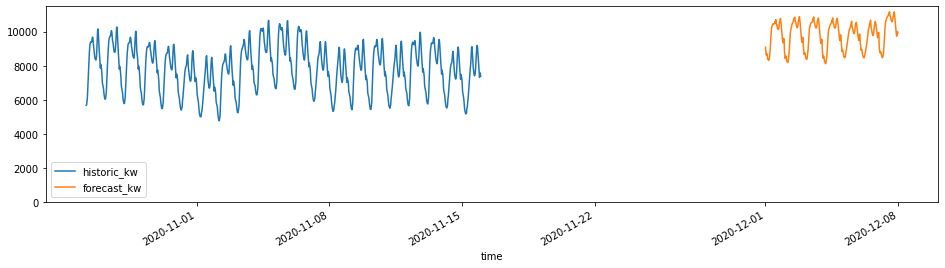

In [24]:
# visualize recent load along with our forecast; remember we don't have recent actual load so there is a time-gap. 
to_plot = pd.merge(
    historic["load_kw"][-1000:].to_frame("historic_kw"), 
    lin_reg_prediction.rename(columns={"load_kw": "forecast_kw"}), 
    how='outer', left_index=True, right_index=True
)
to_plot.plot(ylim=0, figsize=(16, 4))     

## 5. Better algorithms

We can see that the prediction is pretty poor, so we can try and use a better algorithm. 

For that we will use h2o as a backend for classic machine learning algorithms, and enda's models on top of them. 

For enda's `H2OModel` to work, we need the `h2o` package:
```bash
pip install h2o
```



In [44]:
import h2o
from enda.ml_backends.h2o_model import H2OModel
import time

In [45]:
# Lets define some algorithms then train and predict with them
all_models = dict()

In [46]:
# keep the basic one for the benchmark
all_models['sk_lin_reg'] = SKLearnLinearRegression()  

# H20's linear regressor
all_models['h2o_lin_reg'] = H2OModel(algo_name="glm", model_id="h2o_glm", target="load_kw", algo_param_dict={})

# a GBM
all_models['h2o_gbm'] = H2OModel(
    algo_name="gbm",
    model_id="h2o_gbm",  # H2O requires a unique model_id for each algo we train with it
    target="load_kw",
    algo_param_dict= {
        "ntrees": [500],
        "max_depth": [5],
        "sample_rate": [0.5],
        "min_rows": [5]
    }
)

# an XGBoost
all_models['h2o_xgboost'] = H2OModel(
    algo_name="xgboost",
    model_id="h2o_xgboost",
    target="load_kw",
    algo_param_dict= {
        "ntrees": [500],
        "max_depth": [5],
        "sample_rate": [0.8],
        "min_rows": [10]
    },
)

# an random forest
all_models['h2o_rf'] = H2OModel(
    algo_name="randomforest",
    model_id="h2o_randomforest",
    target="load_kw",
    algo_param_dict= {
        "ntrees": [300],
        "max_depth": [15],
        "sample_rate": [0.8],
        "min_rows": [10],
        "nbins": [52],
        "mtries": [3]
    }
)


In [47]:
# an algorithm using Enda : "Normlized xgboost using kva"
all_models['enda_n'] = enda.models.NormalizedModel(
    normalized_model = H2OModel(
        algo_name="xgboost",
        model_id="enda_n_xgboost",
        target="load_kw",
        algo_param_dict= {
            "ntrees": [500],
            "max_depth": [5],
            "sample_rate": [0.8],
            "min_rows": [10]
        },
    ),
    target_col = "load_kw",
    normalization_col = "kva",
    columns_to_normalize = ["num_contracts"]
)

In [48]:
# another algorithm using Enda : "glm-stacking of [randomforest, gbm, xgboost]"
_m_randomforest = H2OModel(
    algo_name="randomforest",
    model_id="enda_s_randomforest",
    target="load_kw",
    algo_param_dict= {
        "ntrees": [300],
        "max_depth": [15],
        "sample_rate": [0.8],
        "min_rows": [10],
        "nbins": [52],
        "mtries": [3]
    }
)

_m_gbm = H2OModel(
    algo_name="gbm",
    model_id="enda_s_gbm",
    target="load_kw",
    algo_param_dict= {
        "ntrees": [500],
        "max_depth": [5],
        "sample_rate": [0.5],
        "min_rows": [5]
    }
)

_m_xgboost = H2OModel(
    algo_name="xgboost",
    model_id="enda_s_xgboost",
    target="load_kw",
    algo_param_dict= {
        "ntrees": [500],
        "max_depth": [5],
        "sample_rate": [0.8],
        "min_rows": [10]
    }
)

all_models['enda_s'] = enda.models.StackingModel(
    base_models = {
        "randomforest": _m_randomforest,
        "gbm": _m_gbm,
        "xgboost": _m_xgboost
    },
    final_model = H2OModel(
        algo_name="xgboost",
        model_id="enda_s_xgboost",
        target="load_kw",
        algo_param_dict= {
            "ntrees": [500],
            "max_depth": [5],
            "sample_rate": [0.8],
            "min_rows": [10]
        }
    )
)

In [49]:
# another Enda algorithm : "normalized glm-stacking of [randomforest, gbm, xgboost]"

_m_randomforest = H2OModel(
    algo_name="randomforest",
    model_id="enda_ns_randomforest",
    target="load_kw",
    algo_param_dict= {
        "ntrees": [300],
        "max_depth": [15],
        "sample_rate": [0.8],
        "min_rows": [10],
        "nbins": [52],
        "mtries": [3]
    }
)

_m_gbm = H2OModel(
    algo_name="gbm",
    model_id="enda_ns_gbm",
    target="load_kw",
    algo_param_dict= {
        "ntrees": [500],
        "max_depth": [5],
        "sample_rate": [0.5],
        "min_rows": [5]
    }
)

_m_xgboost = H2OModel(
    algo_name="xgboost",
    model_id="enda_ns_xgboost",
    target="load_kw",
    algo_param_dict= {
        "ntrees": [500],
        "max_depth": [5],
        "sample_rate": [0.8],
        "min_rows": [10]
    }
)

_m_stacking = enda.models.StackingModel(
    base_models = {
        "randomforest": _m_randomforest,
        "gbm": _m_gbm,
        "xgboost": _m_xgboost
    },
    final_model = H2OModel(algo_name="glm", model_id="enda_ns_stacking_glm", target="load_kw", algo_param_dict={})
)

m_enda_ns = enda.models.NormalizedModel(
    normalized_model = _m_stacking,
    target_col = "load_kw",
    normalization_col = "kva",
    columns_to_normalize = ["num_contracts"]
)

#all_models["enda_ns"] = m_enda_ns

In [50]:
# here we do a benchmark, we want to compare with actual data, lets says from 2020-11-01 to 2020-11-15
benchmark_train = train_set[train_set.index < '2020-11-01']
benchmark_test = train_set[train_set.index >= '2020-11-01']

benchmark = benchmark_test["load_kw"].to_frame("actual_load_kw")

benchmark_test = benchmark_test.drop(columns=["load_kw"])

In [51]:
# use the same method as before to predict a portfolio for 2020-11-01 -> 2020-11-15
benchmark_test_portfolio = enda.Contracts.forecast_using_trend(
    portfolio_df=portfolio[portfolio.index < '2020-11-01'],
    start_forecast_date=pd.to_datetime("2020-11-01 00:00:00+01:00"),
    nb_days=15,  
    past_days=50  # only use recent portfolio trend to forecast the next few days
)
benchmark_test['kva'] = benchmark_test_portfolio['kva']
benchmark_test['num_contracts'] = benchmark_test_portfolio['num_contracts']
benchmark_test

/Users/emmanuel.charon/Documents/CodeProjects/enercoop/enda/venv/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


,kva,num_contracts,tso_forecast_load_mw,t_weighted,t_smooth,minuteofday,dayofweek,month,minuteofday_cos,minuteofday_sin,dayofweek_cos,dayofweek_sin,dayofyear_cos,dayofyear_sin,lockdown,public_holiday,nb_school_areas_off,extra_long_weekend
time,,,,,,,,,,,,,,,,,,
2020-11-01 00:00:00+01:00,808741.0,95079.6,47900.0,12.67,12.37,0,6,11,1.000000,0.000000,0.62349,-0.781831,0.500000,-0.866025,0.0,1.0,3.0,0.0
2020-11-01 00:30:00+01:00,808742.1,95080.1,45800.0,12.68,12.37,30,6,11,0.991445,0.130526,0.62349,-0.781831,0.500000,-0.866025,0.0,1.0,3.0,0.0
2020-11-01 01:00:00+01:00,808743.2,95080.7,43700.0,12.70,12.37,60,6,11,0.965926,0.258819,0.62349,-0.781831,0.500000,-0.866025,0.0,1.0,3.0,0.0
2020-11-01 01:30:00+01:00,808744.4,95081.2,43900.0,12.66,12.37,90,6,11,0.923880,0.382683,0.62349,-0.781831,0.500000,-0.866025,0.0,1.0,3.0,0.0
2020-11-01 02:00:00+01:00,808745.5,95081.8,43200.0,12.63,12.36,120,6,11,0.866025,0.500000,0.62349,-0.781831,0.500000,-0.866025,0.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-15 21:30:00+01:00,809559.9,95476.0,46200.0,12.05,12.01,1290,6,11,0.793353,-0.608761,0.62349,-0.781831,0.691771,-0.722117,0.0,0.0,0.0,0.0
2020-11-15 22:00:00+01:00,809561.0,95476.5,45200.0,11.92,11.97,1320,6,11,0.866025,-0.500000,0.62349,-0.781831,0.691771,-0.722117,0.0,0.0,0.0,0.0
2020-11-15 22:30:00+01:00,809562.2,95477.1,46400.0,11.84,11.96,1350,6,11,0.923880,-0.382683,0.62349,-0.781831,0.691771,-0.722117,0.0,0.0,0.0,0.0


In [52]:
# to train or predict with H2O models, we boot up a local h2o server
h2o.init(nthreads=-1)
h2o.remove_all()  # in case these were left-overs from a previous run


for model_name, model in all_models.items():
    print("Training {} before predicting with it".format(model_name))
    model.train(benchmark_train, target_col='load_kw')
    model_prediction = model.predict(benchmark_test, target_col='load_kw')
    benchmark[model_name] = model_prediction
    


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,31 mins 54 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,1 month and 14 days
H2O_cluster_name:,H2O_from_python_emmanuel_charon_ner1d0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.935 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Training sk_lin_reg before predicting with it
Training h2o_lin_reg before predicting with it
Training h2o_gbm before predicting with it
Training h2o_xgboost before predicting with it
Training h2o_rf before predicting with it
Training enda_n before predicting with it
Training enda_s before predicting with it


In [53]:
benchmark

,actual_load_kw,sk_lin_reg,h2o_lin_reg,h2o_gbm,h2o_xgboost,h2o_rf,enda_n,enda_s
time,,,,,,,,
2020-11-01 00:00:00+01:00,6817.332090,7416.425380,7402.419440,7212.077053,6834.500000,6486.644627,6898.553380,7342.590611
2020-11-01 00:30:00+01:00,6326.667322,7192.834937,7164.147824,6718.050101,6434.865234,6249.732409,6397.763245,6934.348010
2020-11-01 01:00:00+01:00,6172.223671,6974.797484,6925.876208,6425.362441,6184.006836,6081.550895,6189.502888,6678.388879
2020-11-01 01:30:00+01:00,6050.575318,6993.302836,6948.581960,6255.951603,5982.432617,6038.809069,5925.276788,6534.086667
2020-11-01 02:00:00+01:00,5898.881230,6928.282813,6869.165517,6185.681897,5872.099609,5863.814310,5704.240874,6409.563157
...,...,...,...,...,...,...,...,...
2020-11-15 21:30:00+01:00,7657.293444,7523.043775,7217.819568,7387.095907,7435.265625,7442.723049,7403.828670,7933.974113
2020-11-15 22:00:00+01:00,7317.540759,7390.711424,7104.362731,7116.853558,7111.193848,7269.469868,7239.824757,7664.922843
2020-11-15 22:30:00+01:00,7580.051439,7478.893420,7240.536464,7257.872271,7300.184570,7282.798656,7409.953793,7782.970017


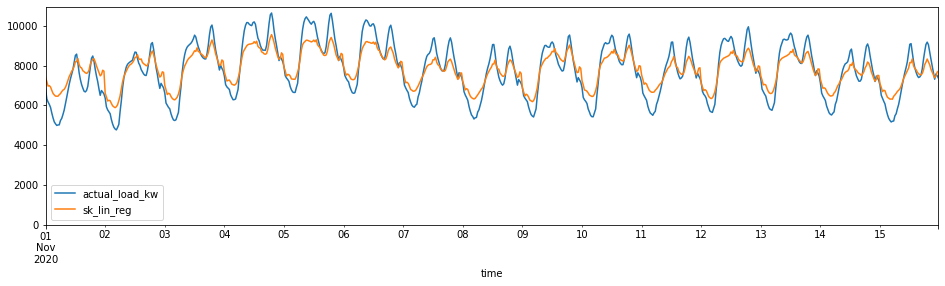

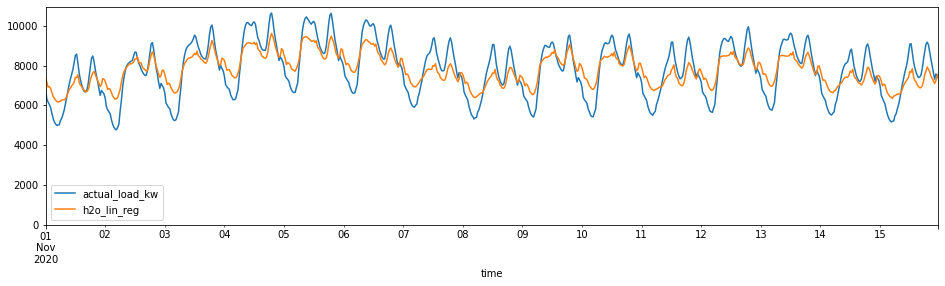

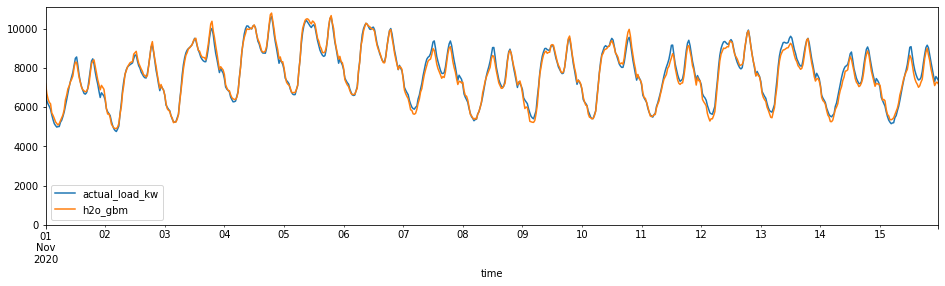

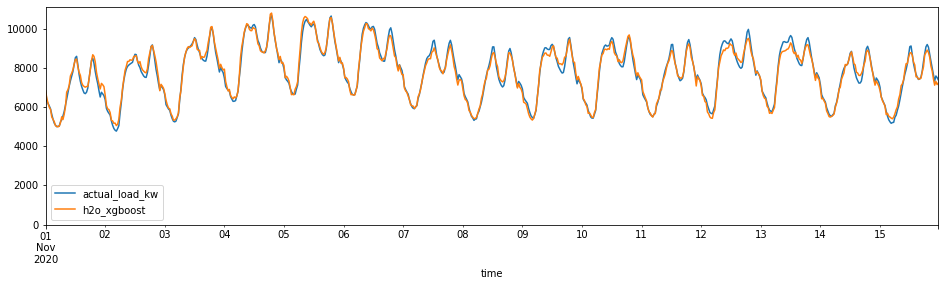

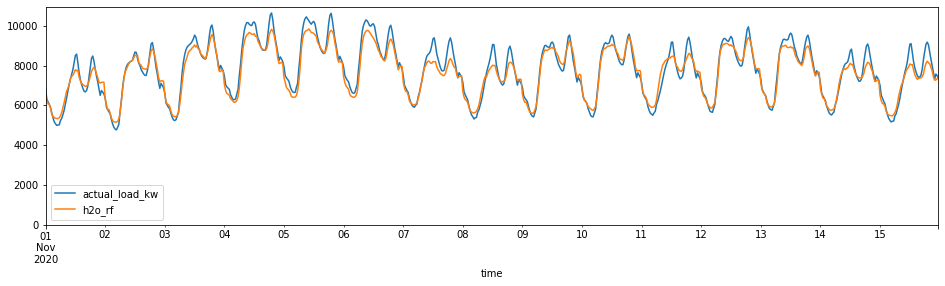

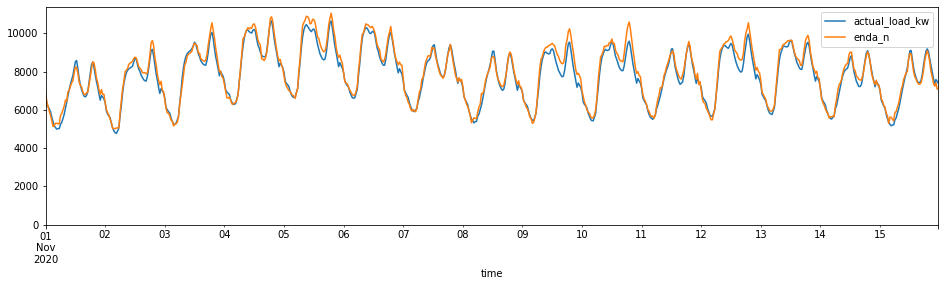

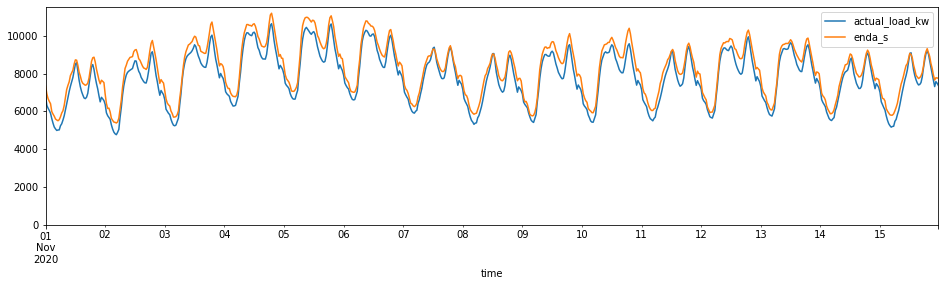

In [54]:
for c in benchmark.columns:
    if c != "actual_load_kw":
        to_plot = benchmark[["actual_load_kw", c]]
        to_plot.plot(ylim=0, figsize=(16, 4)) 

In [55]:
# compute absolute percentage error
benchmark_ape = benchmark.copy(deep=True).drop(columns=["actual_load_kw"])
for c in benchmark_ape.columns:
    benchmark_ape[c] = (benchmark_ape[c] - benchmark["actual_load_kw"]).abs()/benchmark["actual_load_kw"]*100
benchmark_ape.mean()

sk_lin_reg     7.024902
h2o_lin_reg    9.061233
h2o_gbm        2.092034
h2o_xgboost    1.969948
h2o_rf         3.470387
enda_n         2.817230
enda_s         6.199264
dtype: float64

In [56]:
#h2o.cluster().shutdown()
#time.sleep(5)  # wait for h2o to finish shutting down

## 6. Backtesting
